In [1]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from thesis.utils.pytorch import train

In [3]:
# Define data transforms
# MobileNetV2 expects 224x224 input images and specific normalization
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.RandomResizedCrop(224),          # phóng to rồi crop ngẫu nhiên vùng 224x224
        transforms.RandomHorizontalFlip(p=0.5),     # lật ngang ảnh ngẫu nhiên
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # thay đổi màu sắc
        transforms.RandomRotation(degrees=15),      # xoay ngẫu nhiên ±15 độ
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # dịch ảnh
        transforms.RandomPerspective(distortion_scale=0.2, p=0.5), # hiệu ứng phối cảnh
        transforms.ToTensor(),                      # chuyển thành tensor
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([ # Often same as validation for consistent evaluation
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


# base_dir = "/Users/anand/Desktop/1mg/repos/thesis/thesis/data/PlantDoc-Dataset"
base_dir = "/Users/anand/Desktop/temp/Data for Identification of Plant Leaf Diseases Using a 9-layer Deep Convolutional Neural Network/Plant_leave_diseases_dataset_without_augmentation"
base_dataset = datasets.ImageFolder(base_dir)

total_size = len(base_dataset)
print('Total size:', total_size)
train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size

print('Train size:', train_size)
print('Val size:', val_size)
print('Test size:', test_size)

train_data, val_data, test_data = random_split(
    base_dataset, [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

train_data.dataset.transform = data_transforms["train"]
val_data.dataset.transform = data_transforms["val"]
test_data.dataset.transform = data_transforms["test"]

batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_data, shuffle=True, pin_memory=True)


Total size: 55448
Train size: 44358
Val size: 5544
Test size: 5546


In [4]:
from collections import Counter

# These give you the label for each sample in the subset
train_labels = [label for _, label in train_data]
val_labels = [label for _, label in val_data]
test_labels = [label for _, label in test_data]

train_counters = Counter(train_labels)
val_counters =  Counter(val_labels)
test_counters = Counter(test_labels)

In [5]:
x = list(train_counters.keys())
x.sort()
print(x)

y = list(val_counters.keys())
y.sort()
print(y)

z = list(test_counters.keys())
z.sort()
print(z)


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38]


In [6]:
# device = torch.device("mps" if torch.mps.is_available() else "cpu")
device = torch.device("cuda" if torch.cuda.is_available() else "mps")
print("Using device:", device)

Using device: mps


In [ ]:
"""Quantisation step"""

import torch
import torchvision.models

# Check what backends are available
print("Available quantization engines:", torch.backends.quantized.supported_engines)

# Use the first available backend
if torch.backends.quantized.supported_engines:
    torch.backends.quantized.engine = torch.backends.quantized.supported_engines[0]
    print(f"Using quantization engine: {torch.backends.quantized.engine}")
else:
    print("No quantization engines available")

model = torchvision.models.mobilenet_v3_large(weights="DEFAULT")
model = model.to("cpu")
model.eval()

model = torch.quantization.quantize_dynamic(
    model, {torch.nn.Linear}, dtype=torch.qint8
)

Available quantization engines: ['qnnpack', 'none']
Using quantization engine: qnnpack


In [8]:
import torch
import torchvision
model = torchvision.models.mobilenet_v2(weights="DEFAULT")

# Get number of classes
num_classes = len(base_dataset.classes) 
print("Num classes: ", num_classes)

# Check classifier structure and get input features
print("Classifier:", model.classifier)

# For MobileNetV3, the final layer is usually at index -1 or index 3
# Let's try the last layer
final_layer = model.classifier[-1]  # or try model.classifier[3]
in_features = final_layer.in_features
print("No of features: ", in_features)

# Replace the final layer
model.classifier[-1] = nn.Linear(in_features, num_classes)

# Move to device
model = model.to(device)

# Freeze feature extraction layers
for param in model.features.parameters():
    param.requires_grad = False

# Setup loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Num classes:  39
Classifier: Sequential(
  (0): Dropout(p=0.2, inplace=False)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)
No of features:  1280


device mps
============================== Epoch 1/30


Train:   0%|          | 0/694 [00:00<?, ?it/s]

/Users/anand/Desktop/1mg/repos/thesis/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Val: 100%|██████████| 5546/5546 [00:52<00:00, 104.70it/s]


Train:	Accuracy: 0.8487	Loss: 0.7416
Valid:	Accuracy: 0.9392	Loss: 0.2701
Time taken: 191.09 seconds

============================== Epoch 2/30


Val: 100%|██████████| 5546/5546 [00:49<00:00, 111.42it/s]


Train:	Accuracy: 0.9423	Loss: 0.2454
Valid:	Accuracy: 0.9504	Loss: 0.1872
Time taken: 179.53 seconds

============================== Epoch 3/30


Val: 100%|██████████| 5546/5546 [00:50<00:00, 109.92it/s]


Train:	Accuracy: 0.9557	Loss: 0.1789
Valid:	Accuracy: 0.9538	Loss: 0.1565
Time taken: 180.70 seconds

============================== Epoch 4/30


Val: 100%|██████████| 5546/5546 [00:49<00:00, 111.49it/s]


Train:	Accuracy: 0.9594	Loss: 0.1492
Valid:	Accuracy: 0.9609	Loss: 0.1371
Time taken: 178.65 seconds

============================== Epoch 5/30


Val: 100%|██████████| 5546/5546 [00:49<00:00, 111.65it/s]


Train:	Accuracy: 0.9652	Loss: 0.1292
Valid:	Accuracy: 0.9621	Loss: 0.1260
Time taken: 176.87 seconds

============================== Epoch 6/30


Val: 100%|██████████| 5546/5546 [00:50<00:00, 110.90it/s]


Train:	Accuracy: 0.9672	Loss: 0.1171
Valid:	Accuracy: 0.9654	Loss: 0.1178
Time taken: 177.38 seconds

============================== Epoch 7/30


Val: 100%|██████████| 5546/5546 [00:50<00:00, 109.01it/s]


Train:	Accuracy: 0.9697	Loss: 0.1052
Valid:	Accuracy: 0.9659	Loss: 0.1110
Time taken: 180.55 seconds

============================== Epoch 8/30


Val: 100%|██████████| 5546/5546 [00:50<00:00, 109.24it/s]


Train:	Accuracy: 0.9714	Loss: 0.0987
Valid:	Accuracy: 0.9675	Loss: 0.1045
Time taken: 185.73 seconds

============================== Epoch 9/30


Val: 100%|██████████| 5546/5546 [00:50<00:00, 108.82it/s]


Train:	Accuracy: 0.9731	Loss: 0.0916
Valid:	Accuracy: 0.9677	Loss: 0.1094
Time taken: 184.51 seconds

============================== Epoch 10/30


Val: 100%|██████████| 5546/5546 [00:52<00:00, 105.65it/s]


Train:	Accuracy: 0.9737	Loss: 0.0876
Valid:	Accuracy: 0.9657	Loss: 0.1037
Time taken: 187.74 seconds

============================== Epoch 11/30


Val: 100%|██████████| 5546/5546 [00:52<00:00, 105.40it/s]


Train:	Accuracy: 0.9753	Loss: 0.0835
Valid:	Accuracy: 0.9672	Loss: 0.0981
Time taken: 187.19 seconds

============================== Epoch 12/30


Val: 100%|██████████| 5546/5546 [00:50<00:00, 110.89it/s]


Train:	Accuracy: 0.9747	Loss: 0.0821
Valid:	Accuracy: 0.9666	Loss: 0.1004
Time taken: 181.13 seconds

============================== Epoch 13/30


Val: 100%|██████████| 5546/5546 [00:53<00:00, 102.72it/s]


Train:	Accuracy: 0.9766	Loss: 0.0775
Valid:	Accuracy: 0.9665	Loss: 0.0966
Time taken: 189.57 seconds

============================== Epoch 14/30


Val: 100%|██████████| 5546/5546 [00:48<00:00, 113.67it/s]


Train:	Accuracy: 0.9772	Loss: 0.0744
Valid:	Accuracy: 0.9661	Loss: 0.1014
Time taken: 185.73 seconds

============================== Epoch 15/30


Val: 100%|██████████| 5546/5546 [00:49<00:00, 111.63it/s]


Train:	Accuracy: 0.9770	Loss: 0.0737
Valid:	Accuracy: 0.9679	Loss: 0.0968
Time taken: 180.65 seconds

============================== Epoch 16/30


Val: 100%|██████████| 5546/5546 [00:50<00:00, 109.96it/s]


Train:	Accuracy: 0.9770	Loss: 0.0705
Valid:	Accuracy: 0.9697	Loss: 0.0948
Time taken: 183.11 seconds

============================== Epoch 17/30


Val: 100%|██████████| 5546/5546 [00:49<00:00, 111.13it/s]


Train:	Accuracy: 0.9771	Loss: 0.0706
Valid:	Accuracy: 0.9693	Loss: 0.0930
Time taken: 178.84 seconds

============================== Epoch 18/30


Val: 100%|██████████| 5546/5546 [00:49<00:00, 111.16it/s]


Train:	Accuracy: 0.9778	Loss: 0.0686
Valid:	Accuracy: 0.9686	Loss: 0.0937
Time taken: 178.40 seconds

============================== Epoch 19/30


Val: 100%|██████████| 5546/5546 [00:49<00:00, 111.12it/s]


Train:	Accuracy: 0.9798	Loss: 0.0650
Valid:	Accuracy: 0.9702	Loss: 0.0905
Time taken: 177.38 seconds

============================== Epoch 20/30


Val: 100%|██████████| 5546/5546 [00:49<00:00, 111.73it/s]


Train:	Accuracy: 0.9781	Loss: 0.0654
Valid:	Accuracy: 0.9697	Loss: 0.0908
Time taken: 176.82 seconds

============================== Epoch 21/30


Val: 100%|██████████| 5546/5546 [00:50<00:00, 110.89it/s]


Train:	Accuracy: 0.9790	Loss: 0.0638
Valid:	Accuracy: 0.9695	Loss: 0.0901
Time taken: 179.31 seconds

============================== Epoch 22/30


Val: 100%|██████████| 5546/5546 [00:50<00:00, 110.59it/s]


Train:	Accuracy: 0.9788	Loss: 0.0650
Valid:	Accuracy: 0.9677	Loss: 0.0957
Time taken: 180.21 seconds

============================== Epoch 23/30


Val: 100%|██████████| 5546/5546 [00:48<00:00, 113.53it/s]


Train:	Accuracy: 0.9795	Loss: 0.0618
Valid:	Accuracy: 0.9684	Loss: 0.0942
Time taken: 179.19 seconds

============================== Epoch 24/30


Val: 100%|██████████| 5546/5546 [00:47<00:00, 117.07it/s]


Train:	Accuracy: 0.9796	Loss: 0.0613
Valid:	Accuracy: 0.9713	Loss: 0.0882
Time taken: 177.61 seconds

============================== Epoch 25/30


Val: 100%|██████████| 5546/5546 [00:48<00:00, 115.15it/s]


Train:	Accuracy: 0.9798	Loss: 0.0619
Valid:	Accuracy: 0.9690	Loss: 0.0924
Time taken: 178.33 seconds

============================== Epoch 26/30


Val: 100%|██████████| 5546/5546 [00:48<00:00, 114.90it/s]


Train:	Accuracy: 0.9809	Loss: 0.0584
Valid:	Accuracy: 0.9670	Loss: 0.0941
Time taken: 179.43 seconds

============================== Epoch 27/30


Val: 100%|██████████| 5546/5546 [00:47<00:00, 115.72it/s]


Train:	Accuracy: 0.9795	Loss: 0.0605
Valid:	Accuracy: 0.9690	Loss: 0.0935
Time taken: 179.38 seconds

============================== Epoch 28/30


Val: 100%|██████████| 5546/5546 [00:47<00:00, 115.56it/s]


Train:	Accuracy: 0.9801	Loss: 0.0602
Valid:	Accuracy: 0.9701	Loss: 0.0917
Time taken: 178.65 seconds

============================== Epoch 29/30


Val: 100%|██████████| 5546/5546 [00:48<00:00, 114.98it/s]


Train:	Accuracy: 0.9803	Loss: 0.0581
Valid:	Accuracy: 0.9686	Loss: 0.0938
Time taken: 178.29 seconds

============================== Epoch 30/30


Val: 100%|██████████| 5546/5546 [00:48<00:00, 114.67it/s]


Train:	Accuracy: 0.9805	Loss: 0.0582
Valid:	Accuracy: 0.9675	Loss: 0.0964
Time taken: 178.90 seconds

Best Epoch: 26
Train Accuracy: 0.9809 | Train Loss: 0.0584
Test Accuracy: 0.9670  | Test Loss: 0.0941
Model saved to: model_mobile_net_v2_plantvillage_epoch26.pth
✅ Accuracy: 0.9675 (5366/5546)


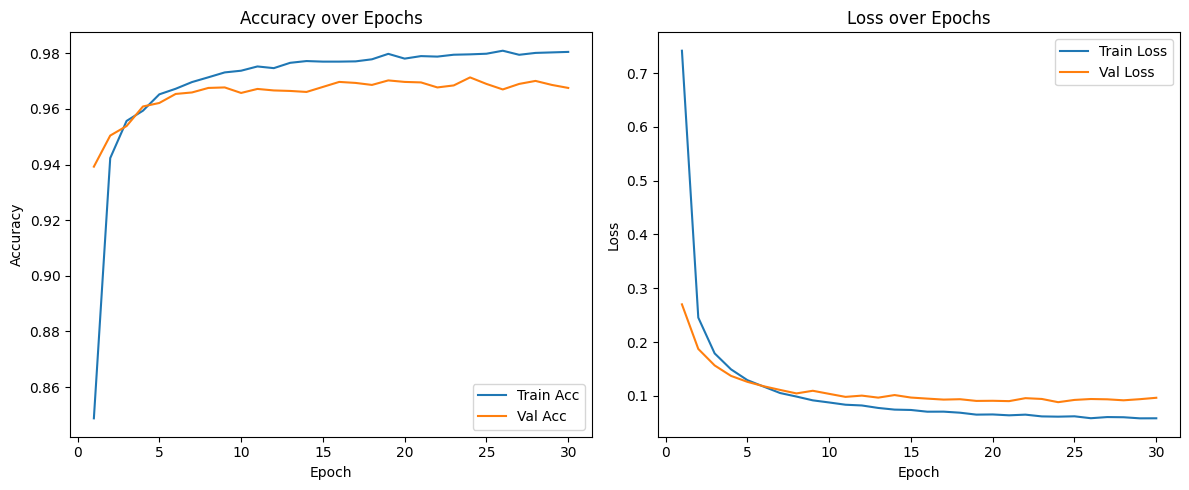

In [9]:
from thesis.utils.pytorch import train_with_plots


num_epochs = 30
print("device", device)
train_with_plots("mobile_net_v2", num_epochs, model, train_data, train_loader, test_data, test_loader, criterion, optimizer, device)